In [1]:
# from datetime import datetime
import datetime as dt
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import tensorflow as tf
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip') 
DB_URI = f'postgresql://{os.environ["PG_USER"]}:{os.environ["PG_PASS"]}@{os.environ["PG_URL"]}/{os.environ["PG_DB"]}'
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')
try:
    engine = sa.create_engine(DB_URI)
    with engine.connect() as connection:
        # data = pd.read_sql_table(table_name='stocks_1m_price', con=connection)
        # data = pd.read_sql_table(table_name='stocks_daily_price', con=connection)
        data = pd.read_sql_query(f"SELECT * FROM stocks_daily_price WHERE symbol in ('AAPL', 'AMD', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM', 'MSFT')", con=connection)
        data['date'] = pd.to_datetime(data['date'])
        print(data.shape)
        print(data.info())
        print(data.head())
except Exception as e:
    print(e)
finally:
    if 'engine' in locals():
        engine.dispose()

(82307, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82307 entries, 0 to 82306
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  82307 non-null  object        
 1   date    82307 non-null  datetime64[ns]
 2   volume  82307 non-null  int64         
 3   close   82307 non-null  float64       
 4   open    82307 non-null  float64       
 5   high    82307 non-null  float64       
 6   low     82307 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 4.4+ MB
None
  symbol       date     volume     close      open      high       low
0   CSCO 1990-02-16  940636800  0.051204  0.000000  0.052930  0.048903
1   CSCO 1990-12-17  105120000  0.102408  0.102408  0.104134  0.100682
2   CSCO 1990-12-18   83260800  0.100107  0.102408  0.102408  0.097805
3   CSCO 1990-12-19   93427200  0.102983  0.101257  0.103558  0.099531
4   CSCO 1990-12-20  111974400  0.101257  0.

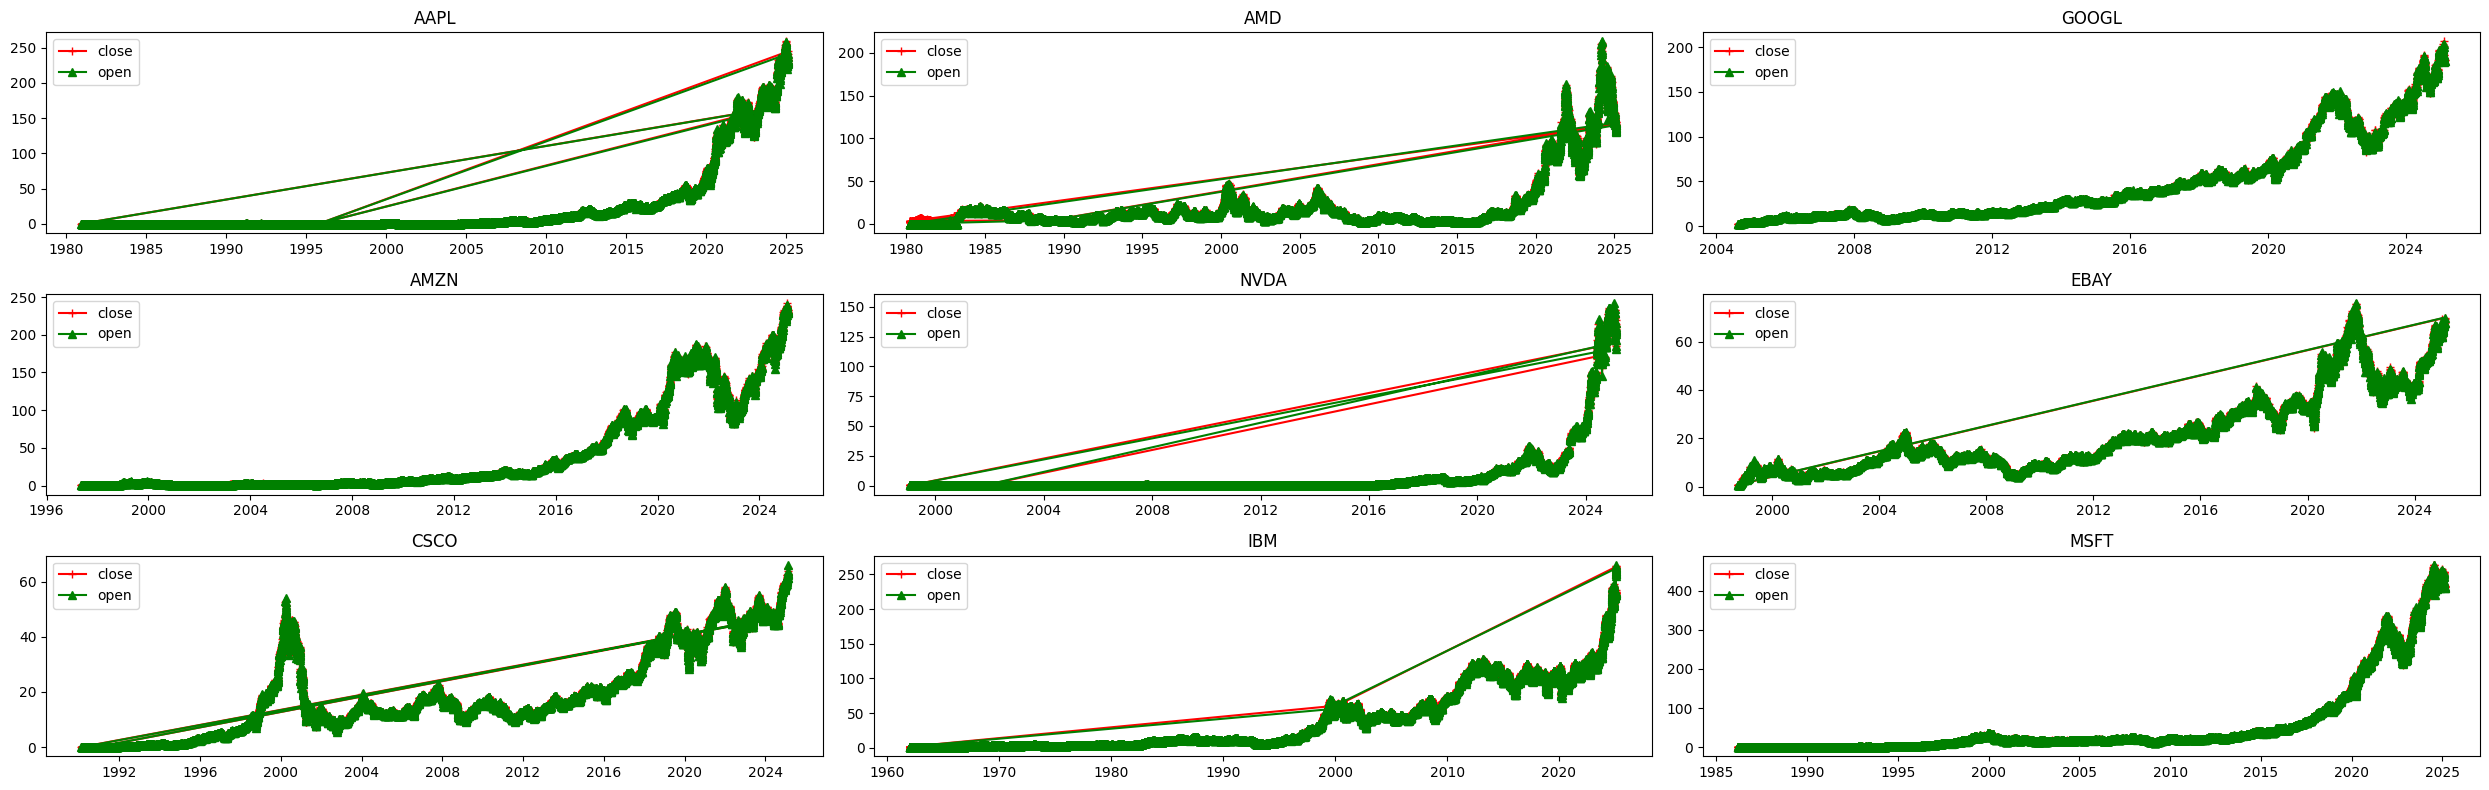

In [3]:
# Define the list of companies you want to plot
companies = ['AAPL', 'AMD', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM', 'MSFT']

# PLot the open and close prices of the stocks
plt.figure(figsize=(25, 8)) 
for index, company in enumerate(companies, 1): 
    plt.subplot(3, 3, index) 
    c = data[data['symbol'] == company] 
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+") 
    plt.plot(c['date'], c['open'], c="g", label="open", marker="^") 
    plt.title(company) 
    plt.legend() 
    plt.tight_layout()

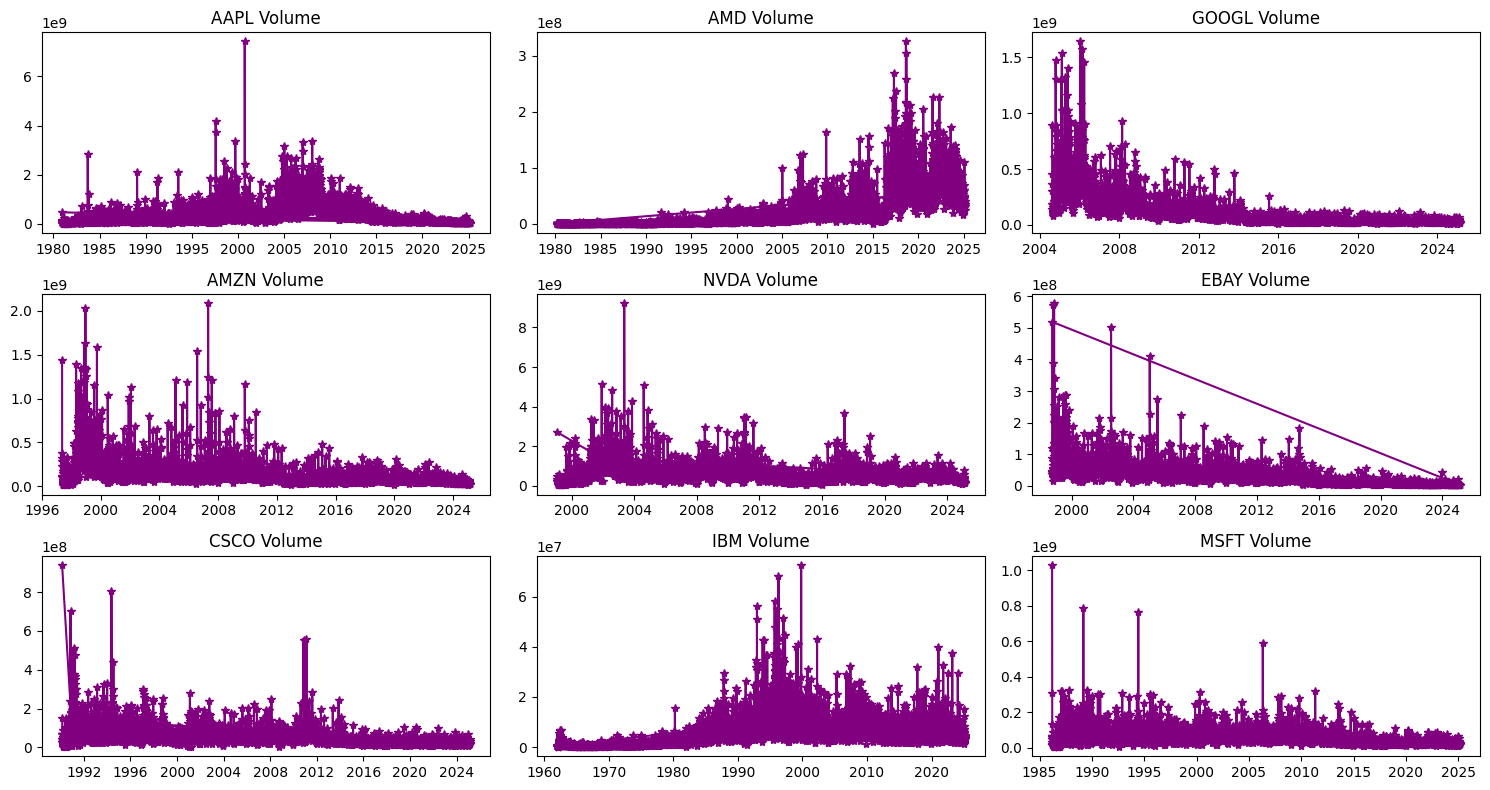

In [4]:
# Volume as a function of time
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['symbol'] == company]
    plt.plot(c['date'], c['volume'], c='purple', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()

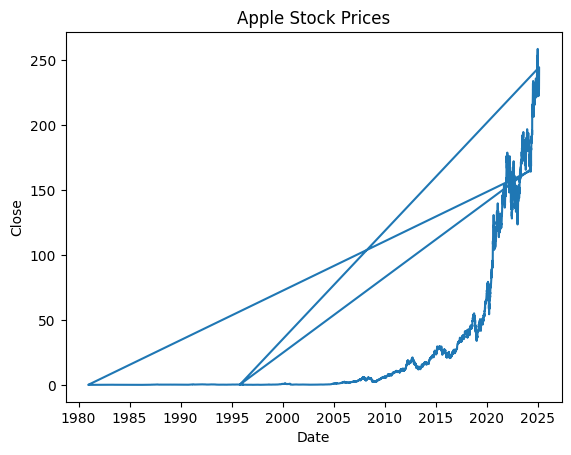

In [12]:
# Plot the adjusted close price of Apple
apple = data[data['symbol'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > dt.datetime(2021,1,1)) & (apple['date']<dt.datetime(2024,1,1))]
plt.plot(apple['date'],apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [13]:
# Split the data into training and testing

close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

10579


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
checkpoint_path = "stock_price.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    callbacks=[cp_callback])

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040
Epoch 1: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0040
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013
Epoch 2: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0013
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016
Epoch 3: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0016
Epoch 4/10
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013
Epoch 4: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0013
Epoch 5/10
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
Epoch 5: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0011
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012
Epoch 6: saving model to stock_price.weights.h5
329/329 ━━━━━━━━━━━

In [17]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MSE 263.07133999446063
RMSE 16.21947409734547


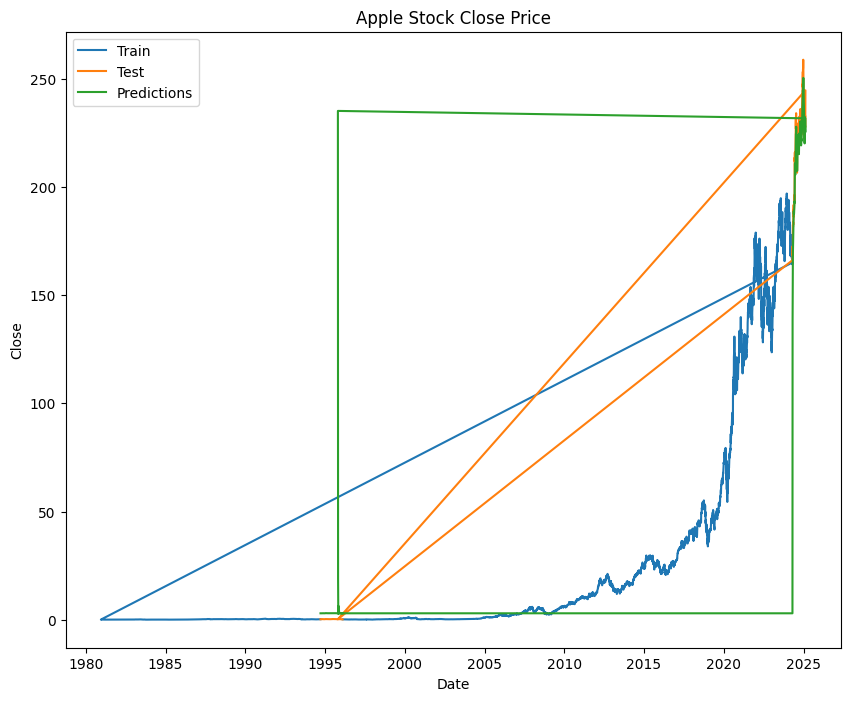

In [18]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])